In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import json 
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle

%matplotlib inline


In [2]:
# read csv file into pandas dataframe 

df_users = pd.read_csv('relax_users_data.csv')

df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [3]:
df_users.shape

(8823, 11)

In [4]:
df_users.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopt_status                    int64
dtype: object

In [5]:
df_users.adopt_status.value_counts(normalize=True)

0    0.812309
1    0.187691
Name: adopt_status, dtype: float64

In [6]:
df_users.groupby(['adopt_status']).last_session_creation_time.mean()

adopt_status
0    1.375596e+09
1    1.395221e+09
Name: last_session_creation_time, dtype: float64

In [7]:
df_users[['adopt_status','last_session_creation_time']].describe()

,adopt_status,last_session_creation_time
count,8823.000000,8.823000e+03
mean,0.187691,1.379279e+09
std,0.390488,1.953116e+07
min,0.000000,1.338452e+09
25%,0.000000,1.363195e+09
50%,0.000000,1.382888e+09
75%,0.000000,1.398443e+09
max,1.000000,1.402067e+09


In [8]:
df_users[df_users['adopt_status'] == 1].last_session_creation_time.describe()

count    1.656000e+03
mean     1.395221e+09
std      1.341866e+07
min      1.341244e+09
25%      1.399693e+09
50%      1.401256e+09
75%      1.401801e+09
max      1.401926e+09
Name: last_session_creation_time, dtype: float64

In [9]:
df_users[df_users['adopt_status'] == 0].last_session_creation_time.describe()

count    7.167000e+03
mean     1.375596e+09
std      1.886094e+07
min      1.338452e+09
25%      1.359985e+09
50%      1.377737e+09
75%      1.392963e+09
max      1.402067e+09
Name: last_session_creation_time, dtype: float64

In [10]:
np.sort(df_users.org_id.unique())[-100:]

array([317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416])

In [11]:
len(np.sort(df_users.org_id.unique()))

417

In [12]:
df_users.org_id.value_counts()[0:30]

0     228
1     172
2     150
3     125
4     122
6     102
9      91
7      88
5      87
10     68
8      67
14     66
17     58
12     57
11     56
18     54
20     50
13     50
33     47
15     47
22     46
25     44
31     44
24     44
16     44
23     43
27     43
28     42
21     41
34     40
Name: org_id, dtype: int64

In [13]:
# Boolean mask:filter out non-adopters, leaving adopters data only
df_users[df_users['adopt_status'] == 1].org_id.value_counts()[0:30]

4     17
1     16
7     16
2     15
3     14
9     14
13    14
0     12
5     12
62    12
6     11
58    11
44    10
24    10
20    10
10    10
31    10
8     10
82     9
35     9
34     9
52     9
33     9
61     9
30     8
16     8
63     8
11     8
72     8
49     8
Name: org_id, dtype: int64

In [14]:
# Boolean mask:filter out adopters, leaving non-adopters data only
#df_users[df_users['adopt_status'] == 0].org_id.value_counts()[0:30]

## Convert Categorical Features

In [15]:
# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02


cle = LabelEncoder()
df_users['creation_source_label'] = cle.fit_transform(df_users['creation_source'])

# convert string into date time object
df_users.creation_time = df_users.creation_time.apply(pd.to_datetime)

df_users.dtypes

user_id                                int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopt_status                           int64
creation_source_label                  int64
dtype: object

In [16]:
df_users.columns

Index([u'user_id', u'creation_time', u'name', u'email', u'creation_source',
       u'last_session_creation_time', u'opted_in_to_mailing_list',
       u'enabled_for_marketing_drip', u'org_id', u'invited_by_user_id',
       u'adopt_status', u'creation_source_label'],
      dtype='object')

In [17]:
df_users.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt_status,creation_source_label
count,8823.000000,8.823000e+03,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000,8823.000000
mean,6019.821716,1.379279e+09,0.252295,0.151989,142.572254,5980.495394,0.187691,1.807775
std,3464.251001,1.953116e+07,0.434354,0.359031,124.176422,3394.211361,0.390488,1.373882
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,3017.500000,1.363195e+09,0.000000,0.000000,30.000000,3071.000000,0.000000,1.000000
50%,6034.000000,1.382888e+09,0.000000,0.000000,109.000000,5947.000000,0.000000,1.000000
75%,9029.500000,1.398443e+09,1.000000,0.000000,239.000000,8857.250000,0.000000,3.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000,4.000000


In [18]:
df_users.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopt_status                     0
creation_source_label            0
dtype: int64

In [19]:
df_users.creation_source.value_counts()

ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64

In [20]:
df_users.groupby(['creation_source','adopt_status']).size()

creation_source     adopt_status
GUEST_INVITE        0               1219
                    1                369
ORG_INVITE          0               2614
                    1                574
PERSONAL_PROJECTS   0                592
                    1                172
SIGNUP              0               1596
                    1                302
SIGNUP_GOOGLE_AUTH  0               1146
                    1                239
dtype: int64

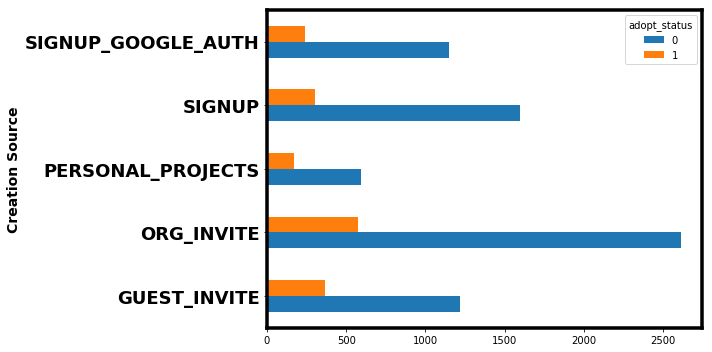

In [21]:
df_users.groupby(['creation_source','adopt_status']).size().unstack().plot(kind='barh',figsize=(10,5))
plt.yticks(fontsize=18,weight='bold')
plt.ylabel('Creation Source', fontsize=14, weight='bold')
plt.gca().spines['top'].set_linewidth(3.5)
plt.gca().spines['right'].set_linewidth(3.5)
plt.gca().spines['bottom'].set_linewidth(3.5)
plt.gca().spines['left'].set_linewidth(3.5)
plt.tight_layout()

#plt.savefig('Relax_users_barplot_creation_source_adopt.png')

In [22]:
df_users.groupby(['org_id','adopt_status']).size()

org_id  adopt_status
0       0               216
        1                12
1       0               156
        1                16
2       0               135
        1                15
3       0               111
        1                14
4       0               105
        1                17
5       0                75
        1                12
6       0                91
        1                11
7       0                72
        1                16
8       0                57
        1                10
9       0                77
        1                14
10      0                58
        1                10
11      0                48
        1                 8
12      0                51
        1                 6
13      0                36
        1                14
14      0                61
        1                 5
                       ... 
401     0                 9
        1                 3
402     0                11
        1                 1

In [23]:
df_users.groupby(['enabled_for_marketing_drip','adopt_status']).size()

enabled_for_marketing_drip  adopt_status
0                           0               6083
                            1               1399
1                           0               1084
                            1                257
dtype: int64

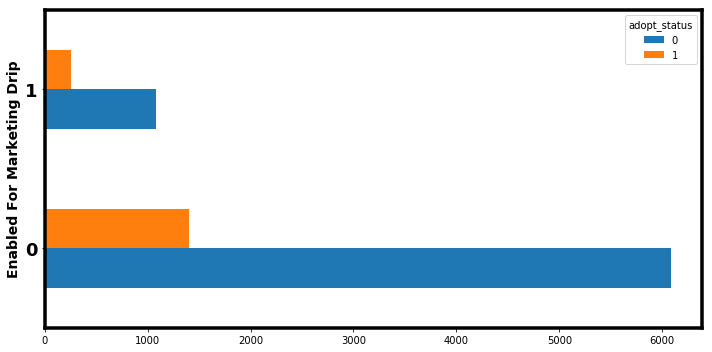

In [24]:
df_users.groupby(['enabled_for_marketing_drip','adopt_status']).size().unstack().plot(kind='barh',figsize=(10,5))
plt.yticks(fontsize=18,weight='bold')
plt.ylabel('Enabled For Marketing Drip', fontsize=14, weight='bold')
plt.gca().spines['top'].set_linewidth(3.5)
plt.gca().spines['right'].set_linewidth(3.5)
plt.gca().spines['bottom'].set_linewidth(3.5)
plt.gca().spines['left'].set_linewidth(3.5)
plt.tight_layout()
#plt.savefig('Relax_users_barplot_EnabledMarketing_adopt.png')

In [25]:
df_users.groupby(['opted_in_to_mailing_list','adopt_status']).size()

opted_in_to_mailing_list  adopt_status
0                         0               5370
                          1               1227
1                         0               1797
                          1                429
dtype: int64

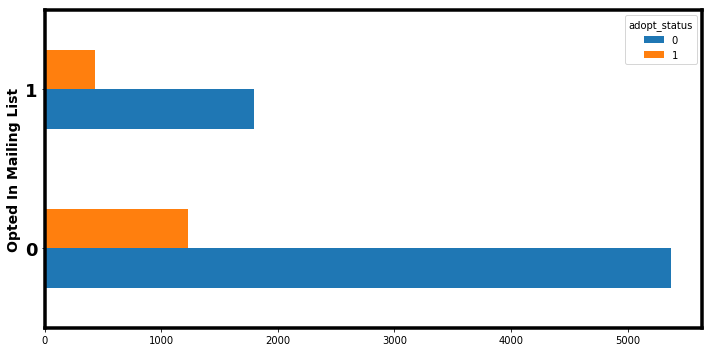

In [26]:
df_users.groupby(['opted_in_to_mailing_list','adopt_status']).size().unstack().plot(kind='barh',figsize=(10,5))
plt.yticks(fontsize=18,weight='bold')
plt.ylabel('Opted In Mailing List', fontsize=14, weight='bold')
plt.gca().spines['top'].set_linewidth(3.5)
plt.gca().spines['right'].set_linewidth(3.5)
plt.gca().spines['bottom'].set_linewidth(3.5)
plt.gca().spines['left'].set_linewidth(3.5)
plt.tight_layout()
#plt.savefig('Relax_users_barplot_OptedInMailing_adopt.png')